WARNING: Don't use the API to download large quantities of data. Use the files available for download instead following these instructions: https://pro.dp.la/developers/bulk-download

## Import Libraries

In [ ]:
%pip install yake

In [1]:
import os
import time
import json

from getpass import getpass
import httpx
import re
import yake
import matplotlib.pyplot as plt

## Setting up the API key variable

In [2]:
API_URL="https://api.dp.la/v2/"
ENV_VAR = "DPLA_API_KEY"
TIMEOUT=30.0
FALLBACK_DATA_URL = "https://raw.githubusercontent.com/UCSB-Library-Research-Data-Services/intro2APIs/refs/heads/main/data/"

In [3]:
key= os.getenv(ENV_VAR)

# This method avoids hardcoding the API key in the script
# The variable is persistent during the session
if not key:
    key = getpass(f"Enter your DPLA API key: ").strip()
    if not key:
        raise ValueError("No API key provided.")
    os.environ[ENV_VAR] = key
    
print(f"API key set in environment variable {ENV_VAR}.")

API key set in environment variable DPLA_API_KEY.


## Helping Functions

In [4]:
def _join_list(x, sep="; ", keep_first_only=False):
    if isinstance(x, list):
        if keep_first_only and len(x) > 0:
            return str(x[0])
        return sep.join(str(v) for v in x if v is not None)
    return "" if x is None else str(x)

In [5]:
def top_n(d, n=10):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=True)[:n])

In [6]:
def search_items(query, verbose=False, facets=None, **parameters):
    """
    Search DPLA items with given query and parameters.
    
    Args:
        query (str): The search query string. It's possible to use logical operators 
        (AND, OR, NOT). Additionally, you can use wildcards (*) for partial matches.
        **parameters: Facets and filter parameters, such as:
            - page_size (int): Number of results per page (default is 10, maximum is 100).
            - dataProvider (str): Filter results by one or multiple data provider. 
                (e.g., "UC Santa Barbara, Library, Department of Special Research Collections")
            - provider_name (str): Filter results by a specific provider name. 
                (e.g., "California Digital Library")
            - resource_type (str): Filter results by item type. Available types are
                "text", "image", "sound", "moving image", "physical object"
            - after (str): Filter results with sourceResource.date after the specified date (YYYY-MM-DD).
            - before (str): Filter results with sourceResource.date before the specified date (YYYY-MM-DD).
            - exact_field_match (str): true or false. "The exact_field_match behavior is applied to all 
               specific-field parameters. It does not affect the behavior of the “simple search” q parameter 
               (which can be combined with fields, and with exact_field_match).
            - Other facets and filters as documented in the DPLA API documentation.
            
    """
    
    base_url = f"{API_URL}items"
    params = {
        "q": query,
        "api_key": os.getenv(ENV_VAR),
    }
    
    # Handle facets
    if facets:
        params["facets"] = facets
    
    # Aliases for DPLA parameters
    provider_name = parameters.pop("provider_name", None)
    if provider_name:
        parameters["provider.name"] = provider_name
    
    after = parameters.pop("after", None)
    if after:
        parameters["sourceResource.date.after"] = after
        
    before = parameters.pop("before", None)
    if before:
        parameters["sourceResource.date.before"] = before
        
    resource_type = parameters.pop("resource_type", None)
    if resource_type:
        parameters["sourceResource.type"] = resource_type.lower()
    
    # Add remaining parameters
    for key, value in parameters.items():
        params[key] = value
        
    # Make the request
    with httpx.Client(timeout=TIMEOUT) as client:
        response = client.get(base_url, params=params)
    
    print(f"Request URL: {response.url}") if verbose else None
    
    response.raise_for_status() 
    return response.json()

In [7]:
def search_all_items(query, max_items=100, sleep=0.5, verbose=False, facets=None, **parameters):
    """
    Collect up to max_items across pages.
    
    Args:
        query (str): The search query string. It's possible to use logical operators 
            (AND, OR, NOT). Additionally, you can use wildcards (*) for partial matches.
        max_items (int): Maximum number of items to retrieve. For number of elements per page, 
            use the page_size parameter in **parameters.
        sleep (float): Time to wait between requests to avoid hitting rate limits.
        **parameters: Additional facets and filter parameters as documented in the DPLA API documentation.
    """
    all_docs = []
    page = 1
    page_size = int(parameters.get("page_size", 100))
    if page_size > 100:
        page_size = 100
        print("page_size cannot exceed 100. Setting to 100.")
        
    while len(all_docs) < max_items:
        parameters['page'] = page
        data = search_items(query, verbose=verbose, facets=facets, **parameters)
        docs = data.get('docs', [])
        if not docs:
            break  # No more results
        all_docs.extend(docs)
        
        # stop if we've reached max_items
        if len(all_docs) >= max_items:
            break
        
        page += 1
        time.sleep(sleep)
        
    return all_docs[:max_items]
    

In [8]:
try:
    mysearch = search_items(
        "artificial AND intelligence",
        facets="sourceResource.date.begin,sourceResource.date.end",
        page_size=25,
        page=1,
        verbose=True
        )
except httpx.HTTPStatusError as e:
    print(f"HTTP error occurred: {e}. Using preloaded data instead.")
    r = httpx.get(f"{FALLBACK_DATA_URL}preloaded_search_results.json")
    r.raise_for_status()
    mysearch = r.json()
    

# download the preloaded data for the next steps
print(f"{mysearch.get('count')} results found.") if isinstance(mysearch, dict) else print(f"{len(mysearch)} results found.")
print(f"Facets: {mysearch.get('facets')}") if isinstance(mysearch, dict) else None

Request URL: https://api.dp.la/v2/items?q=artificial+AND+intelligence&api_key=f%3Bqw3orebfg%3Bp%5Bqbre&facets=sourceResource.date.begin%2CsourceResource.date.end&page_size=25&page=1
HTTP error occurred: Client error '403 Forbidden' for url 'https://api.dp.la/v2/items?q=artificial+AND+intelligence&api_key=f%3Bqw3orebfg%3Bp%5Bqbre&facets=sourceResource.date.begin%2CsourceResource.date.end&page_size=25&page=1'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403. Using preloaded data instead.
3379 results found.
Facets: {'sourceResource.date.begin': {'_type': 'date_histogram', 'entries': [{'count': 4, 'time': '2026'}, {'count': 128, 'time': '2025'}, {'count': 173, 'time': '2024'}, {'count': 100, 'time': '2023'}, {'count': 34, 'time': '2022'}, {'count': 34, 'time': '2021'}, {'count': 33, 'time': '2020'}, {'count': 23, 'time': '2019'}, {'count': 15, 'time': '2018'}, {'count': 3, 'time': '2017'}, {'count': 4, 'time': '2016'}, {'count': 6, 'time': '2015'}, 

## Let's play with the faceted elements

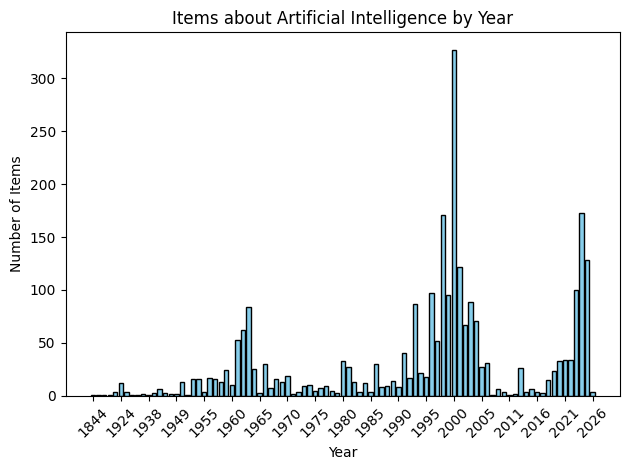

In [9]:
# Visualize the histogram of entries dates

facets_list = mysearch.get('facets').get('sourceResource.date.begin').get('entries')

years = [d['time'] for d in facets_list][::-1] # We use [::-1] to reverse the order
counts = [d['count'] for d in facets_list][::-1]

plt.bar(years, counts, color='skyblue', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Number of Items')
plt.title('Items about Artificial Intelligence by Year')
plt.xticks(range(0, len(years), 5), [years[i] for i in range(0, len(years), 5)], rotation=45)
plt.tight_layout()
plt.show()

In [10]:
waves = [
    ("first_wave", "1955-1975"),
    ("second_wave", "1990-2005"),
    ("third_wave", "2018-2026"),
]

In [11]:
# create a pool of results for each period
ai_results = {}

try:
    for period_name, date_range in waves:
        print(f"Searching for AI items in the {period_name}: {date_range}")
        ai_results[period_name] = search_all_items(
            "artificial AND intelligence",
            max_items=3000,
            facets="sourceResource.date.begin,sourceResource.date.end",
            page_size=50,
            after=date_range.split('-')[0],
            before=date_range.split('-')[1],
            verbose=True
        )
        print(f"Found {len(ai_results[period_name])} items for period {period_name}.\n")
except httpx.HTTPStatusError as e:
    print(f"HTTP error occurred: {e}. Using preloaded data instead.")
    r = httpx.get(f"{FALLBACK_DATA_URL}ai_results_by_wave.json")
    r.raise_for_status()
    ai_results = r.json()
    for period_name in ai_results:
        print(f"Loaded {len(ai_results[period_name])} items for period {period_name} from preloaded data.\n")

Searching for AI items in the first_wave: 1955-1975
Request URL: https://api.dp.la/v2/items?q=artificial+AND+intelligence&api_key=f%3Bqw3orebfg%3Bp%5Bqbre&facets=sourceResource.date.begin%2CsourceResource.date.end&page_size=50&page=1&sourceResource.date.after=1955&sourceResource.date.before=1975
HTTP error occurred: Client error '403 Forbidden' for url 'https://api.dp.la/v2/items?q=artificial+AND+intelligence&api_key=f%3Bqw3orebfg%3Bp%5Bqbre&facets=sourceResource.date.begin%2CsourceResource.date.end&page_size=50&page=1&sourceResource.date.after=1955&sourceResource.date.before=1975'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403. Using preloaded data instead.
Loaded 427 items for period first_wave from preloaded data.

Loaded 1310 items for period second_wave from preloaded data.

Loaded 544 items for period third_wave from preloaded data.



In [12]:
ai_results_summary = {period: len(items) for period, items in ai_results.items()}
print("AI Results Summary by Period:")
for period, count in ai_results_summary.items():
    print(f"{period}: {count} items")

AI Results Summary by Period:
first_wave: 427 items
second_wave: 1310 items
third_wave: 544 items


In [13]:
ai_results['first_wave'][400].get('sourceResource')

{'@id': 'http://dp.la/api/items/607326c580d76ec37c21240b67e8a571#SourceResource',
 'date': [{'begin': '1962', 'displayDate': '1962', 'end': '1962'}],
 'description': ['Construction site showing excavation work and heavy machinery for the East Stacks addition to Watson Library. Multiple bulldozers and construction equipment are visible in the excavated area, with workers overseeing the construction. A multi-story building appears in the background.',
  'Descriptive metadata for this item has been generated in part using AI (artificial intelligence) technologies and may be incomplete, misleading, or inaccurate. Please contact the Kenneth Spencer Research Library with specific questions or concerns.'],
 'format': ['Electronic; image/tiff'],
 'identifier': ['https://digital.lib.ku.edu/ku-uaphotos/36078'],
 'rights': ['This Item may be protected by copyright and/or related rights. You are free to use this Item in any way that is permitted by the copyright and related rights legislation that

In [14]:
ai_results['first_wave'][400].get('sourceResource').get('subject')[1].get('name')

'Construction equipment'

In [15]:
## subject pools

ai_subjects = {}

for period, items in ai_results.items():
    subjects = {}
    for item in items:
        source_res = item.get('sourceResource', {})
        item_subjects = source_res.get('subject', [])
        for subj in item_subjects:
            name = subj.get('name')
            terms = re.split(r'[^\w\s]+', name) if name else []
            for term in terms:
                if term is not None and term.strip() != "":
                    term = term.strip().lower()
                    subjects[term] = subjects.get(term, 0) + 1
    ai_subjects[period] = subjects
    


In [16]:
# top five subjects per period

top = 10

for period, subjects in ai_subjects.items():
    sorted_subjects = sorted(subjects.items(), key=lambda x: x[1], reverse=True)[:top]
    print(f"Top {top} subjects for {period}:")
    for subj, count in sorted_subjects:
        print(f"  {subj}: {count}")
    print()

Top 10 subjects for first_wave:
  university of kansas: 558
  libraries: 423
  academic libraries: 384
  library buildings: 100
  construction: 87
  university buildings: 59
  construction sites: 47
  library construction: 47
  building construction: 39
  gothic revival architecture: 34

Top 10 subjects for second_wave:
  university of kansas: 1439
  libraries: 1302
  academic libraries: 1014
  library exhibits: 528
  display cases: 500
  books: 124
  library employees: 86
  book displays: 73
  library exhibitions: 71
  exhibitions: 71

Top 10 subjects for third_wave:
  united states: 1031
  artificial intelligence: 530
  law and legislation: 164
  technological innovations: 100
  government policy: 91
  machine learning: 75
  science: 67
  technology: 65
  communications: 60
  china: 58



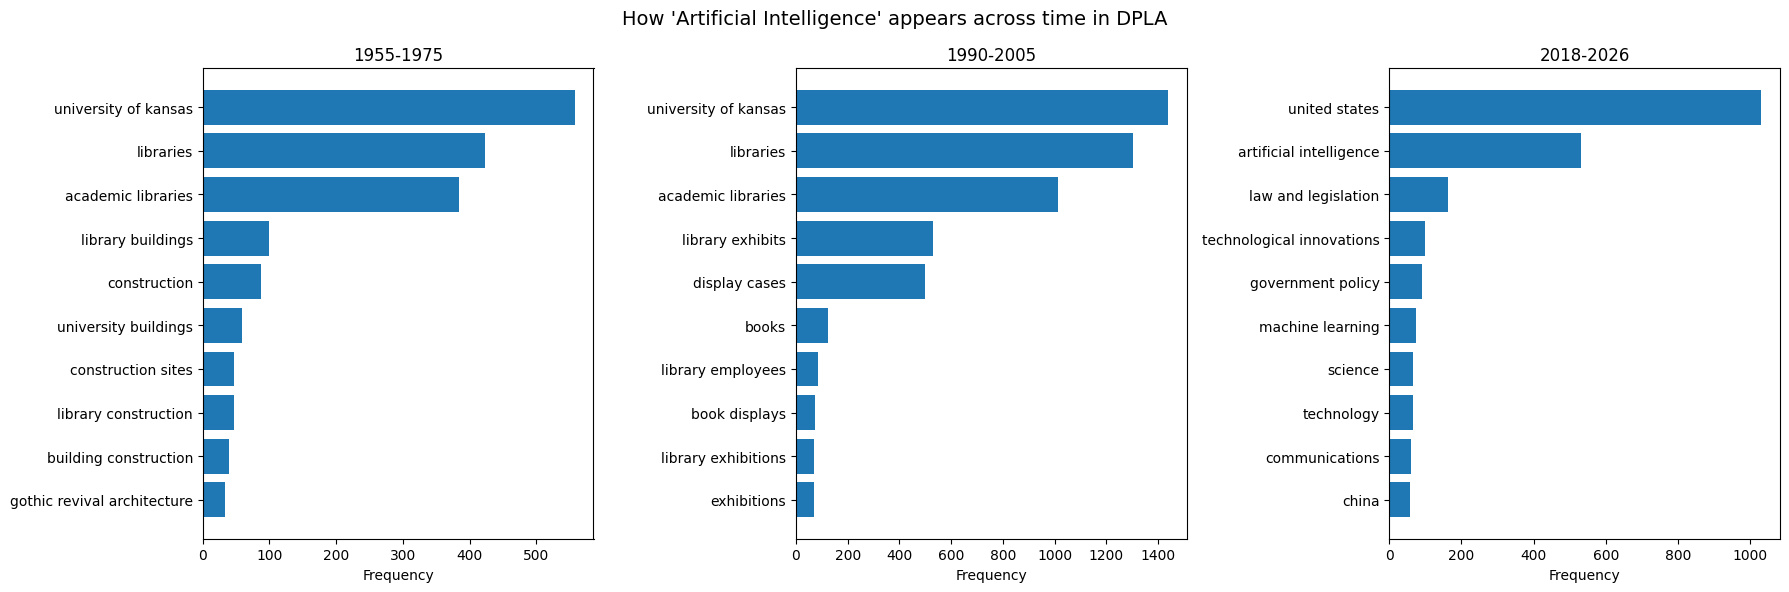

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

for ax, (key, title) in zip(axes, waves):
    data = top_n(ai_subjects[key], 10)
    terms = list(data.keys())[::-1]
    counts = list(data.values())[::-1]

    ax.barh(terms, counts)
    ax.set_title(title)
    ax.set_xlabel("Frequency")

plt.suptitle("How 'Artificial Intelligence' appears across time in DPLA", fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
ai_keywords = {}

kw_extractor = yake.KeywordExtractor(lan="en", n=2, top=5)

for period, items in ai_results.items():
    period_keywords = {}
    for item in items:
        source_res = item.get('sourceResource', {})
        title = _join_list(source_res.get('title', ''), keep_first_only=True)
        description = _join_list(source_res.get('description', ''), keep_first_only=True)
        text = f"{title} {description}".lower()
        
        keywords = kw_extractor.extract_keywords(text)
        for kw, score in keywords:
            period_keywords[kw] = period_keywords.get(kw, 0) + 1
            
    ai_keywords[period] = period_keywords

In [19]:
top = 10

for period, keywords in ai_keywords.items():
    sorted_keywords = sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:top]
    print(f"Top {top} keywords for {period}:")
    for kw, count in sorted_keywords:
        print(f"  {kw}: {count}")
    print()

Top 10 keywords for first_wave:
  watson library: 204
  stacks addition: 87
  east stacks: 64
  site showing: 44
  library east: 40
  white photograph: 35
  display case: 25
  photograph showing: 25
  west stacks: 25
  contact sheet: 23

Top 10 keywords for second_wave:
  display case: 380
  library exhibit: 230
  watson library: 105
  exhibit display: 105
  display cases: 91
  interior view: 61
  library staff: 57
  handling training: 55
  contact sheet: 55
  spencer research: 54

Top 10 keywords for third_wave:
  artificial intelligence: 228
  updated irregularly: 118
  united states: 62
  indexing program: 60
  states senate: 48
  library program: 47
  eighteenth congress: 38
  government publishing: 35
  machine learning: 33
  artificial: 20



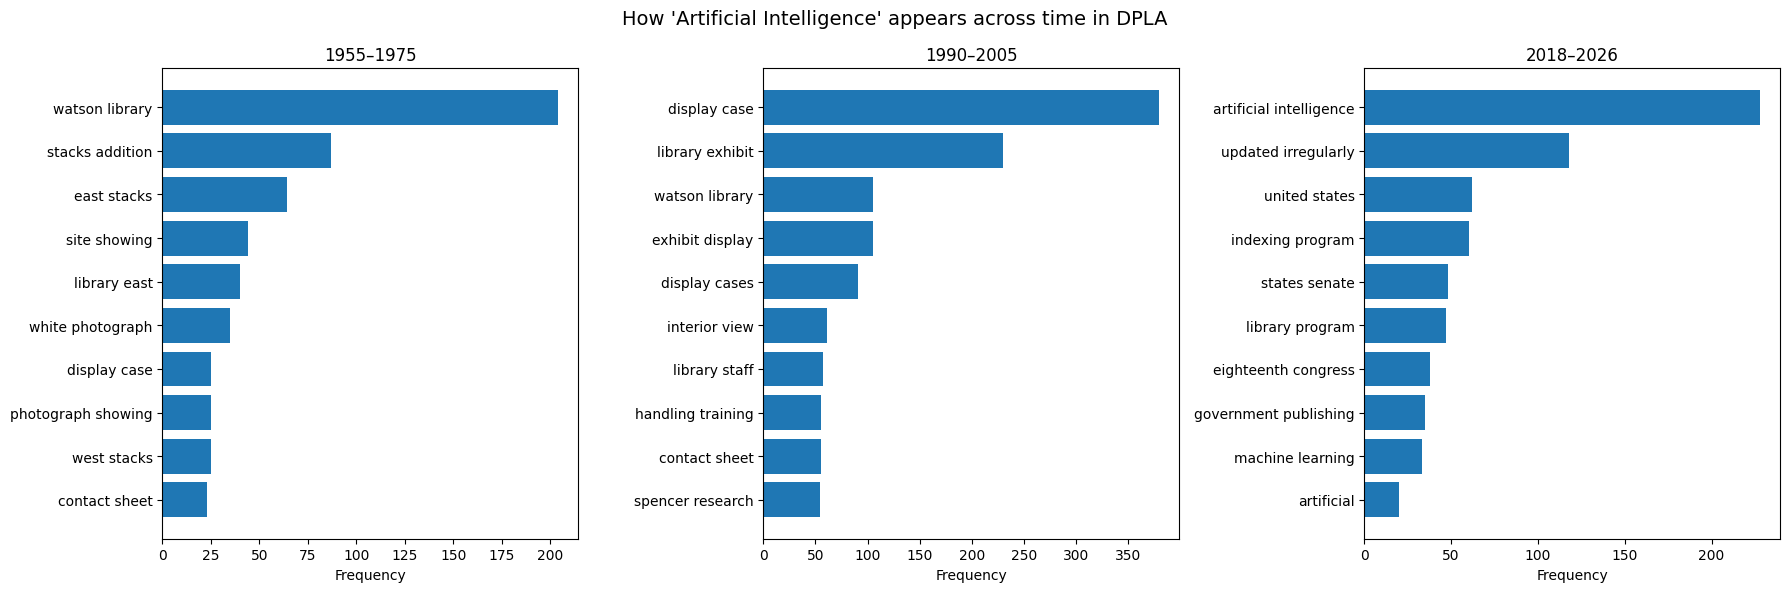

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

waves = [
    ("first_wave", "1955–1975"),
    ("second_wave", "1990–2005"),
    ("third_wave", "2018–2026"),
]

for ax, (key, title) in zip(axes, waves):
    data = top_n(ai_keywords[key], 10)
    terms = list(data.keys())[::-1]
    counts = list(data.values())[::-1]

    ax.barh(terms, counts)
    ax.set_title(title)
    ax.set_xlabel("Frequency")

plt.suptitle("How 'Artificial Intelligence' appears across time in DPLA", fontsize=14)
plt.tight_layout()
plt.show()